In [1]:
sys.path.insert(0, '/home/shengq2/program/spcount/src')

from spcount.Species import Species
from spcount.Query import Query
from spcount.count_util import read_species_taxonomy_map, read_file_map, read_query_list, output_rank_list

import pandas as pd


In [2]:
species_file = "/data/cqs/references/spcount/20220406_bacteria.taxonomy.txt"
species_taxonomy_map = read_species_taxonomy_map(species_file)
species_names = list(species_taxonomy_map.keys())
print(species_taxonomy_map[species_names[0]])


{'species': 'Escherichia coli', 'genus': 'Escherichia', 'family': 'Enterobacteriaceae', 'order': 'Enterobacterales', 'class': 'Gammaproteobacteria', 'phylum': 'Proteobacteria', 'superkingdom': 'Bacteria'}


In [3]:
result_dir="/scratch/vickers_lab/projects/20220417_bacteria_genome/nonhost_genome/refseq_bacteria_table/result/"

In [4]:
file_map = read_file_map(result_dir + "RA_4893_2__fileList1.list")
print(file_map)

OrderedDict([('IgAKO_SB_1', '/scratch/vickers_lab/projects/20200625_4893_2_RA_smRNA_mouse_v5_byTiger/intermediate_data/refseq_bacteria_bowtie_count/result/IgAKO_SB_1.txt.gz'), ('IgAKO_SB_2', '/scratch/vickers_lab/projects/20200625_4893_2_RA_smRNA_mouse_v5_byTiger/intermediate_data/refseq_bacteria_bowtie_count/result/IgAKO_SB_2.txt.gz')])


In [5]:
samples=list(file_map.keys())
samples

['IgAKO_SB_1', 'IgAKO_SB_2']

In [6]:
query_list = read_query_list(None, file_map, True)
print(query_list[0])

In [7]:
ranks = [ 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']


In [8]:
q1=query_list[0]
q1.to_unique_rank(species_taxonomy_map, ranks)
print(q1.unique_rank_name)
print(q1.unique_rank)


Pseudomonas
genus


In [9]:
for rank in ranks:
  rank_name = q1.aggregate_to_rank(species_taxonomy_map, rank)
  print(f"{rank}: {rank_name}")

genus: Pseudomonas
family: Pseudomonadaceae
order: Pseudomonadales
class: Gammaproteobacteria
phylum: Proteobacteria
superkingdom: Bacteria


In [10]:
aggregate_rate = 0.95

for rank in ranks:
  rank_map = {}
  for q in query_list:
    rank_name = q.aggregate_to_rank(species_taxonomy_map, rank)
    if rank_name not in rank_map:
      rank_map[rank_name] = Species(rank_name, rank)
    rank_map[rank_name].add_query(q)
  rank_objs = list(rank_map.values())
  for rank_obj in rank_objs:
    rank_obj.sum_query_count()
  rank_objs.sort(key=lambda x:x.query_count, reverse=True)
  output_rank_list(result_dir + f"RA_4893_2.{rank}_aggregated.count", rank_objs, samples)
  
  


In [94]:

ranks=[ 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']
for q in query_list:
  q.to_unique_rank(species_taxonomy_map, ranks)

rank_list = [q.unique_rank_name for q in query_list]

import pandas as pd
vc=pd.value_counts(rank_list)

rank_map = {}
for q in query_list:
  rank_map[q.unique_rank_name] = q.unique_rank

pvc=pd.DataFrame({'Rank_name':vc.keys(), 'Rank':[rank_map[r] for r in vc.keys()], "Count":vc})
pvc.head()



,Rank_name,Rank,Count
Bacteria,Bacteria,superkingdom,6552
Pseudopuniceibacterium sediminis,Pseudopuniceibacterium sediminis,species,400
Pseudomonas,Pseudomonas,genus,291
Proteobacteria,Proteobacteria,phylum,256
Exiguobacterium profundum,Exiguobacterium profundum,species,173


In [95]:
agg_species_list = {}
for q in query_list:
  agg_species_list.setdefault(q.unique_rank_name, {"rank":q.unique_rank, "sample_map":{}})["sample_map"].setdefault(q.sample, []).append(q)
agg_species_list['Bacteria']

AttributeError: 'Query' object has no attribute 'sample'

In [26]:
qmap = {}
for q in query_list:
  qmap.setdefault(q.unique_rank_name, []).append(len(q.seq))


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame()
for rank in vc.keys()[0:9]:
    # Subset to the airline
    subset = qmap[rank]
    sdf = pd.DataFrame({"Rank":rank, "Length":subset})
    df = pd.concat([df, sdf])

df.head()


,Rank,Length
0,Bacteria,29
1,Bacteria,30
2,Bacteria,46
3,Bacteria,31
4,Bacteria,20


In [74]:
df.index=range(df.shape[0])
df.index.value_counts()


0       1
5381    1
5394    1
5393    1
5392    1
       ..
2688    1
2687    1
2686    1
2685    1
8078    1
Length: 8079, dtype: int64

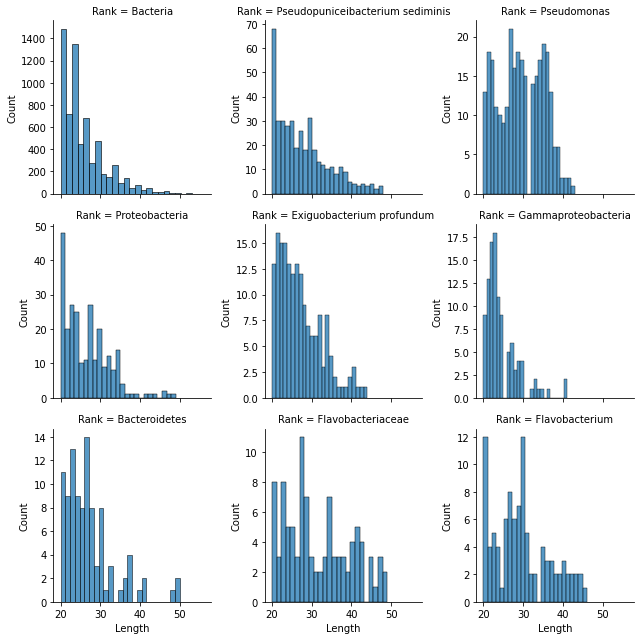

In [79]:
g = sns.FacetGrid(df, col="Rank", col_wrap=3, sharey=False)
g.map(sns.histplot, "Length", bins=25)
g.savefig('/scratch/vickers_lab/projects/20220417_bacteria_genome/nonhost_genome/refseq_bacteria_table/result/top9.readlen.png', dpi=300)
